<a href="https://colab.research.google.com/github/boredanon/machine-learning2023-2/blob/main/proyecto_ML_Jos%C3%A9_del_Solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtaining the Data


Install gspread to obtain the data directly from the google spreadsheet.

Only run this block if:


1) Running on colab


2) Running locally while not having gspread installed in your system

In [38]:
!pip install --upgrade -q gspread

Loading the data from the google spreadsheet.
Do not worry it won't delete anything from your google drive, but the credentials are needed. 👀

In [39]:
import gspread
import pandas as pd
from google.colab import auth
from google.auth import default

# Google mumbo jumbo magic stuff.
auth.authenticate_user()
creds, _ = default()

gc = gspread.authorize(creds)
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1cJZIUTPoYliSej8ZQumPdrvWjcZeRyuEqyC4JyXpx-8/edit#gid=1570725307")
worksheet_A = sh.worksheet("A")
worksheet_B = sh.worksheet("B")

rows_B = worksheet_B.get_all_values()[1:]

rows = worksheet_A.get_all_values() + rows_B

#Like this, otherwise it takes the names as a row!
df = pd.DataFrame(rows[1:], columns = rows[0])

X = df.drop(columns=['Y'])
y = df['Y']

X = X.astype(float)
y = y.astype(float)


Check if it loaded correctly, it should be 480 columns and 93 entries for X.
93 entries and 1 column for y.

In [40]:
print(X.info(), "\n")
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Columns: 480 entries, X1 to X480
dtypes: float64(480)
memory usage: 348.9 KB
None 

<class 'pandas.core.series.Series'>
RangeIndex: 93 entries, 0 to 92
Series name: Y
Non-Null Count  Dtype  
--------------  -----  
93 non-null     float64
dtypes: float64(1)
memory usage: 872.0 bytes
None


In [41]:
print(X.describe())
print(y.describe())

               X1          X2          X3          X4          X5          X6  \
count   93.000000   93.000000   93.000000   93.000000   93.000000   93.000000   
mean   921.198065  922.966667  921.956774  921.920108  924.829462  923.234946   
std     21.580701   23.203403   23.120603   22.511511   21.168588   22.694371   
min    898.170000  898.200000  897.320000  897.560000  901.710000  898.870000   
25%    901.530000  901.860000  900.910000  901.410000  905.570000  902.510000   
50%    904.250000  904.510000  903.540000  904.280000  908.230000  905.360000   
75%    943.910000  947.530000  946.310000  945.570000  947.030000  947.190000   
max    948.090000  951.620000  950.710000  949.700000  951.060000  951.500000   

               X7          X8          X9         X10  ...       X471  \
count   93.000000   93.000000   93.000000   93.000000  ...  93.000000   
mean   921.457419  921.599140  922.459892  922.065376  ...   3.259355   
std     22.962681   22.545082   22.642812   19.7514

## Preprocessing of the data

In [42]:
print(df.isnull().sum())

Y       0
X1      0
X2      0
X3      0
X4      0
       ..
X476    0
X477    0
X478    0
X479    0
X480    0
Length: 481, dtype: int64


In [43]:
from scipy.stats import zscore

# Separate before applying Z score
z_scores = zscore(X)

threshold = 4

outliers_X = (abs(z_scores) > threshold).any(axis=1)

X_without_outliers = X[~outliers_X]
y_without_outliers = y[~outliers_X]

alive = round((1 - (X_without_outliers.shape[0]/X.shape[0]))*100, 2)
print(alive, "% of data points were deleted.")

4.3 % of data points were deleted.


In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_normalized = pd.DataFrame(scaler.fit_transform(X_without_outliers), columns=X.columns)

In [91]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=3)
X_pca.fit(X_normalized)
print(X_pca.explained_variance_ratio_)
print(X_pca.explained_variance_ratio_.cumsum())

X_pca_data = X_pca.transform(X_normalized)
print(X_pca_data.shape)

[0.96570726 0.01310581 0.00507004]
[0.96570726 0.97881308 0.98388311]
(89, 3)


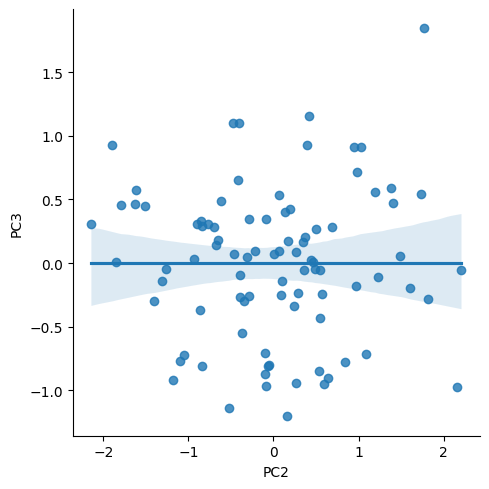

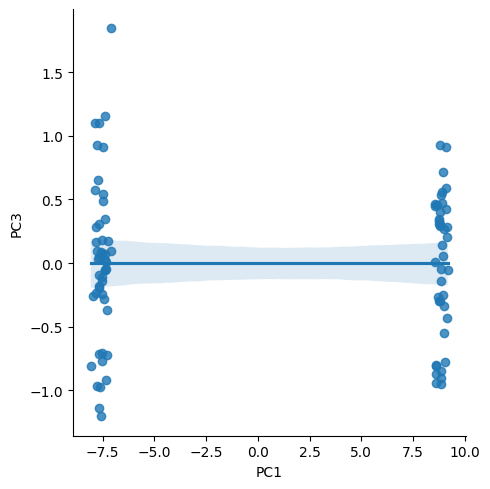

In [93]:
import seaborn as sns

X_pca_df = pd.DataFrame(X_pca_data, columns=['PC1', 'PC2', 'PC3'])
X_pca_df['Y'] = y_without_outliers.copy()

sns.lmplot(x='PC2', y='PC3', data=X_pca_df)
sns.lmplot(x='PC1', y='PC3', data=X_pca_df)